<a href="https://colab.research.google.com/github/GunawanSelayar/deeplearning/blob/main/klasifikasi_Monyet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/monkey

In [2]:
cp /content/drive/MyDrive/deeplearning/deeplearning.zip /content/monkey

In [4]:
!unzip /content/monkey/deeplearning.zip -d /content/monkey

Archive:  /content/monkey/deeplearning.zip
  inflating: /content/monkey/monkey_labels.txt  
  inflating: /content/monkey/training/training/n0/n0018.jpg  
  inflating: /content/monkey/training/training/n0/n0019.jpg  
  inflating: /content/monkey/training/training/n0/n0020.jpg  
  inflating: /content/monkey/training/training/n0/n0021.jpg  
  inflating: /content/monkey/training/training/n0/n0022.jpg  
  inflating: /content/monkey/training/training/n0/n0023.jpg  
  inflating: /content/monkey/training/training/n0/n0024.jpg  
  inflating: /content/monkey/training/training/n0/n0025.jpg  
  inflating: /content/monkey/training/training/n0/n0026.jpg  
  inflating: /content/monkey/training/training/n0/n0027.jpg  
  inflating: /content/monkey/training/training/n0/n0028.jpg  
  inflating: /content/monkey/training/training/n0/n0029.jpg  
  inflating: /content/monkey/training/training/n0/n0030.jpg  
  inflating: /content/monkey/training/training/n0/n0031.jpg  
  inflating: /content/monkey/training/tr

In [11]:
import math                      
import matplotlib.pyplot as plt  
import scipy                    
import cv2                       
import numpy as np               
import glob                      
import os                       
import pandas as pd              
import tensorflow as tf       
import itertools
import random
from random import shuffle       
from tqdm import tqdm           
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
train_dir = Path('/content/monkey/training/training/')
test_dir = Path('/content/monkey/validation/validation/')

In [14]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("/content/monkey/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [15]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [16]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('/content/monkey/training/training/' + label)
        imgfile = random.choice(os.listdir(imgdir))
        img = cv2.imread('/content/monkey/training/training/'+ label +'/'+ imgfile)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                


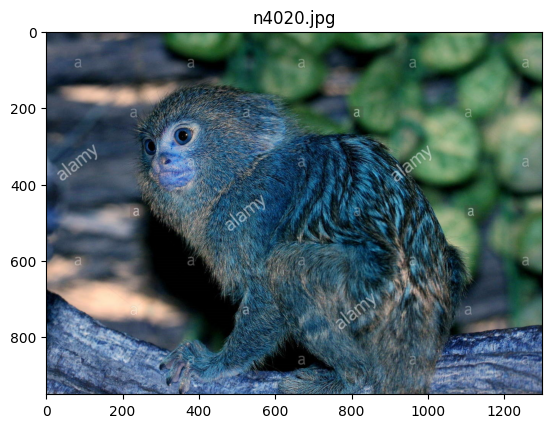

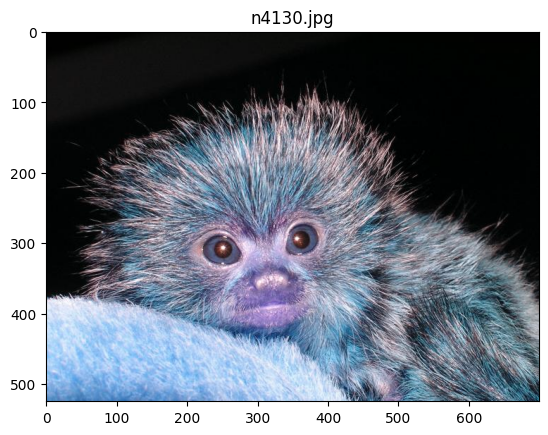

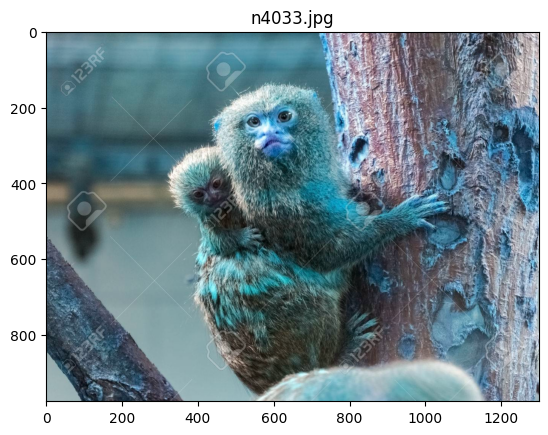

In [17]:
print(labels[4])
image_show(3,'n4')

In [18]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [21]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [23]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=5,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

<ipython-input-23-235ca2e3e247>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 2.2054 - acc: 0.2031
Epoch 1: val_acc improved from 0.13672 to 0.25000, saving model to /content/model.h5f


17/17 [==============================] - 110s 7s/step - loss: 2.2054 - acc: 0.2031 - val_loss: 2.1199 - val_acc: 0.2500
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 2.0898 - acc: 0.2495
Epoch 2: val_acc improved from 0.25000 to 0.30078, saving model to /content/model.h5f


17/17 [==============================] - 114s 7s/step - loss: 2.0898 - acc: 0.2495 - val_loss: 1.9510 - val_acc: 0.3008
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.9559 - acc: 0.3008
Epoch 3: val_acc improved from 0.30078 to 0.41016, saving model to /content/model.h5f


17/17 [==============================] - 107s 6s/step - loss: 1.9559 - acc: 0.3008 - val_loss: 1.7206 - val_acc: 0.4102
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 1.8070 - acc: 0.3598
Epoch 4: val_acc did not improve from 0.41016
17/17 [==============================] - 104s 6s/step - loss: 1.8070 - acc: 0.3598 - val_loss: 1.7302 - val_acc: 0.3633
Epoch 5/5
17/17 [==============================] - ETA: 0s - loss: 1.7439 - acc: 0.3965
Epoch 5: val_acc did not improve from 0.41016
17/17 [==============================] - 98s 6s/step - loss: 1.7439 - acc: 0.3965 - val_loss: 1.6036 - val_acc: 0.4023


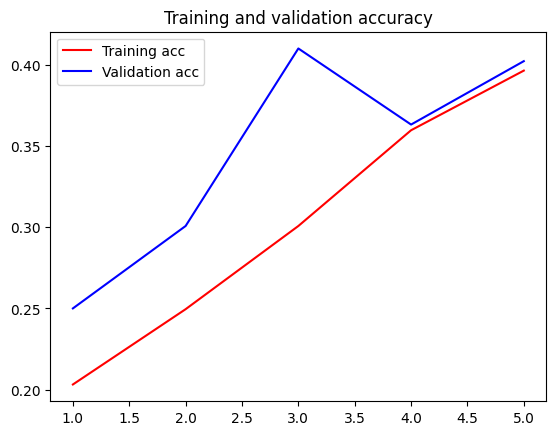

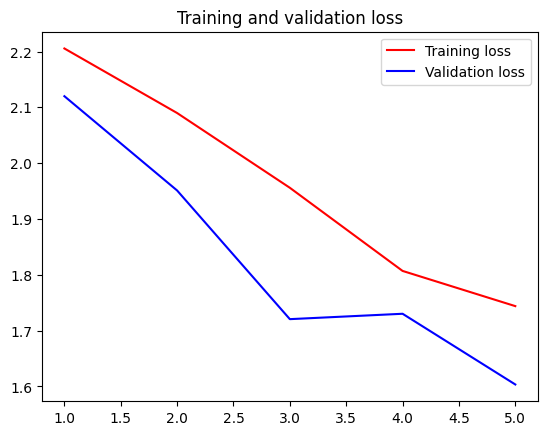

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [25]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

<ipython-input-26-38e8663a3bec>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)


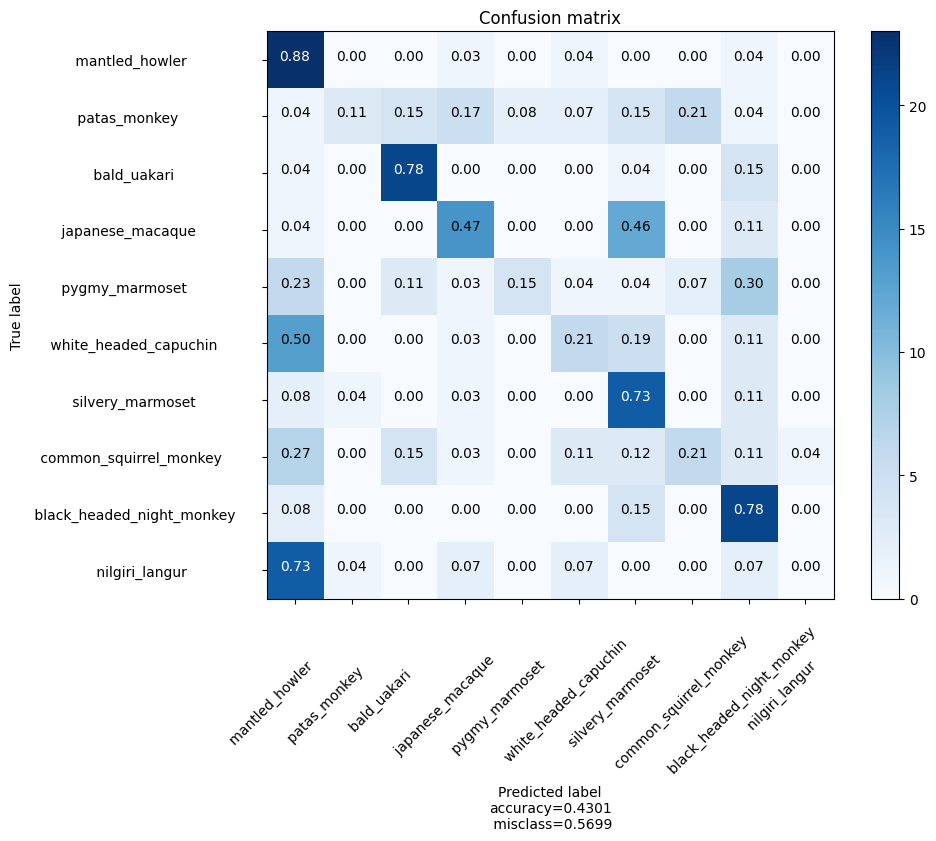

In [26]:
from keras.models import load_model
model_trained = load_model(filepath)
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [27]:
test_list = os.listdir("../input/test-monkeys/")
test_list.sort()
print(test_list)
model_test = load_model(filepath)

FileNotFoundError: ignored